In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from graph_tool.all import *
from sklearn.cluster import AgglomerativeClustering, KMeans
import matplotlib.pyplot as plt
import random

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [ ]:
# Alternative graph creation
nodes = {}
outliers = ["Forest\n", "Plains\n", "Island\n", "Mountain\n", "Swamp\n"]
current_deck = np.full(shape = 110, fill_value = -1)
g2 = Graph(directed = False)
eweight = g2.new_ep("int32_t")
vcount  = g2.new_vp("int32_t")
vname   = g2.new_vp("string")

path = "data_collection/decks/"
for i in range(100):
    file = str(i) + ".txt"
    print("Reading file " + file)
    graphfile = open(path + file)
    count = 0
    for line in graphfile:
        if line != "\n":
            if line in outliers:
                continue
            if line not in nodes:
                v = g2.add_vertex()
                vcount[v] = 1
                vname[v]  = line.rstrip()
                nodes[line] = g2.vertex_index[v]
            else:
                vcount[g2.vertex(nodes[line])] = vcount[g2.vertex(nodes[line])] + 1
            current_deck[count] = nodes[line]
            count = count + 1
        else:
            j = 0
            while current_deck[j] != -1:
                k = j + 1
                while current_deck[k] != -1:
                    e = g2.edge(g2.vertex(current_deck[j]), g2.vertex(current_deck[k]))
                    if (e == None):
                        e = g2.add_edge(g2.vertex(current_deck[j]), g2.vertex(current_deck[k]))
                        eweight[e] = 1
                    else:
                        eweight[e] = eweight[e] + 1
                    k = k + 1
                j = j + 1
            # Reset current deck and count
            current_deck = np.full(shape = 110, fill_value = -1)
            count = 0
    j = 0
    while current_deck[j] != -1:
        k = j + 1
        while current_deck[k] != -1:
            e = g2.edge(g2.vertex(current_deck[j]), g2.vertex(current_deck[k]))
            if (e == None):
                e = g2.add_edge(g2.vertex(current_deck[j]), g2.vertex(current_deck[k]))
                eweight[e] = 1
            else:
                eweight[e] = eweight[e] + 1
            k = k + 1
        j = j + 1
    # Reset current deck and count
    current_deck = np.full(shape = 110, fill_value = -1)
    #print(nodes)
    #print(current_deck)
    graphfile.close()

In [ ]:
g2.vp["vName"]   = vname
g2.vp["vCount"]  = vcount
g2.ep["eWeight"] = eweight

In [ ]:
min_val = min(g2.ep["eWeight"].a)
max_val = max(g2.ep["eWeight"].a)

# Avoid division by zero
if max_val > min_val:
    normalized_eweight = g2.new_edge_property("double")
    normalized_eweight.a = (g2.ep["eWeight"].a - min_val) / (max_val - min_val)
else:
    normalized_eweight = g2.ep["eWeight"]  # No normalization needed

In [ ]:
g2.ep["eNormWeight"] = normalized_eweight

In [ ]:
graph_draw(g2, pos=pos, output="graph2.png")

print("The number of nodes is " + str(g2.num_vertices()))
print("The number of edges is " + str(g2.num_edges()))

## Saving and loading graph from file

In [ ]:
g2.save("graph.gt", fmt='gt')

In [2]:
g2 = Graph(directed = False)
g2.load("graph.gt")

## Compute node positions

In [ ]:
#pos = sfdp_layout(g2)
pos = sfdp_layout(g2, eweight=g2.ep["eWeight"])

In [ ]:
g2.vp["pos"] = pos

Compute betweenness centralities

In [ ]:
vb, eb = betweenness(g2, weight=g2.ep["eWeight"]) # Takes 12 - 20 minutes

In [ ]:
graph_draw(g2, pos=g2.vp["pos"], vertex_fill_color=prop_to_size(vb, 0, 1, power=.1),
           vertex_size=prop_to_size(vb, 1, 12, power=.2), vorder=vb,
           output="betweenness.png")

PageRank metric

In [ ]:
pr = pagerank(g2, weight=g2.ep["eWeight"])

In [ ]:
graph_draw(g2, pos=g2.vp["pos"], vertex_fill_color=prop_to_size(pr, 0, 1, power=.1),
           vertex_size=prop_to_size(pr, 1, 12, power=.2), vorder=pr,
           output="pagerank.png") # 7 minutes

In [ ]:
c = closeness(g2, weight=g2.ep["eWeight"]) # 12 minutes

In [ ]:
graph_draw(g2, pos=g2.vp["pos"], vertex_fill_color=prop_to_size(c, 0, 1, power=.1),
           vertex_size=prop_to_size(c, 1, 12, power=.2), vorder=c,
           output="closeness.png")

In [ ]:
loc_clust = local_clustering(g2, weight=g2.ep["eNormWeight"])

In [ ]:
inv_weight = g2.ep["eWeight"].copy("double").transform(lambda data: 1 / data)

In [ ]:
print(g2.ep["eWeight"][list(g2.edges())[20]], inv_weight[list(g2.edges())[20]])

In [ ]:
fartness = closeness(g2, weight=inv_weight)

## Print the list of properties stored inside the graph

In [3]:
print(g2.list_properties())

vBetweennessClassic       (vertex)  (type: double)
vBetweennessInvNorm       (vertex)  (type: double)
vBetweennessMNorm         (vertex)  (type: double)
vClosenessClassic         (vertex)  (type: double)
vClosenessInvNorm         (vertex)  (type: double)
vClosenessMNorm           (vertex)  (type: double)
vCount                    (vertex)  (type: int32_t)
vLocClusteringClassic     (vertex)  (type: double)
vLocClusteringInvNorm     (vertex)  (type: double)
vLocClusteringMNorm       (vertex)  (type: double)
vName                     (vertex)  (type: string)
vPagerankClassic          (vertex)  (type: double)
vPagerankInvNorm          (vertex)  (type: double)
vPagerankMNorm            (vertex)  (type: double)
eWeight                   (edge)    (type: int32_t)
eWeightInvNorm            (edge)    (type: double)
eWeightMNorm              (edge)    (type: double)
None


In [ ]:
g2.vp["Name"] = g2.new_vp("string")

In [ ]:
g2.vp["vCloseness"] = c

In [ ]:
g2.vp["vName"][2]

In [ ]:
min(g2.ep["eWeight"])

In [ ]:
g2.vp["PageRank"] = pr

In [ ]:
g2.vp["Closeness"] = c

In [ ]:
g2.vp["vBetweenness"] = vb
g2.ep["eBetweenness"] = eb

In [ ]:
g2.vp["vLocClustering"] = loc_clust

## Agglomerative CLustering

In [32]:
np.max(g2.vp["vLocClustering"].get_array())

KeyError: ('v', 'vLocClustering')

In [ ]:
g2.vp["vName"][np.argmax(g2.vp["Closeness"].get_array())]

In [ ]:
closeness_array = g2.vp["Closeness"].get_array()
kth = -20
ind = np.argpartition(closeness_array, kth)[kth:]

print([g2.vp["vName"][index] for index in ind])

In [ ]:
closeness_array = g2.vp["vBetweenness"].get_array()
kth = -20
ind = np.argpartition(closeness_array, kth)[kth:]

print([g2.vp["vName"][index] for index in ind])

In [ ]:
closeness_array = g2.vp["vLocClustering"].get_array()
kth = -50
ind = np.argpartition(closeness_array, kth)[kth:]

print([g2.vp["vName"][index] for index in ind])

In [ ]:
# before using, run cell above
for v in g2.vertices():
    if g2.vp["vName"][v] in [g2.vp["vName"][index] for index in ind]:
        print(g2.vp["vCount"][v])

In [31]:
pagerank_array = g2.vp["vPagerankMNorm"].get_array()
kth = -20
ind = np.argpartition(pagerank_array, kth)[kth:]

print([g2.vp["vName"][index] for index in ind])

['Path to Exile', "Rogue's Passage", 'Farseek', 'Counterspell', 'Myriad Landscape', 'Lightning Greaves', "Commander's Sphere", 'Chromatic Lantern', 'Cultivate', 'Swiftfoot Boots', 'Swords to Plowshares', 'Fellwar Stone', 'Terramorphic Expanse', 'Reliquary Tower', 'Path of Ancestry', 'Evolving Wilds', 'Exotic Orchard', 'Arcane Signet', 'Command Tower', 'Sol Ring']


In [172]:
loc_clust_array = g2.vp["vLocClusteringMNorm"].get_array()
closeness_array = g2.vp["vClosenessMNorm"].get_array()
pagerank_array = g2.vp["vPagerankMNorm"].get_array()

betweennes_array = g2.vp["vBetweennessMNorm"].get_array()

embedding_points = np.transpose(np.vstack((loc_clust_array, closeness_array, betweennes_array)))
print(embedding_points.shape)

(18647, 3)


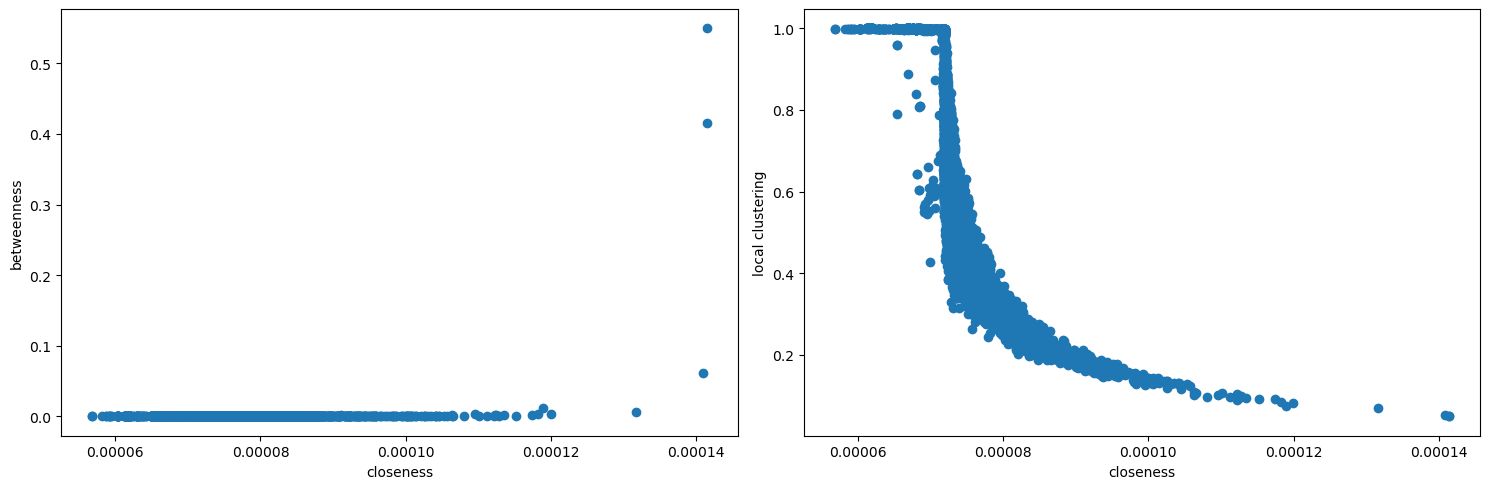

In [179]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(g2.vp["vClosenessMNorm"].get_array(), g2.vp["vBetweennessMNorm"].get_array())
axs[0].set_xlabel("closeness")
axs[0].set_ylabel("betweenness")

axs[1].scatter(g2.vp["vClosenessMNorm"].get_array(), g2.vp["vLocClusteringMNorm"].get_array())
axs[1].set_xlabel("closeness")
axs[1].set_ylabel("local clustering")

plt.tight_layout()
plt.savefig("plot_errors.png", format="png")
plt.show()

In [173]:
k = 6
pred = KMeans(n_clusters=k).fit_predict(embedding_points)
print(pred.shape)

(18647,)


In [ ]:
print(betweenness_array[np.argmax(g2.vp["Closeness"].get_array())], closeness_array[np.argmax(g2.vp["Closeness"].get_array())])
print(embedding_points[np.argmax(g2.vp["Closeness"].get_array()), :])

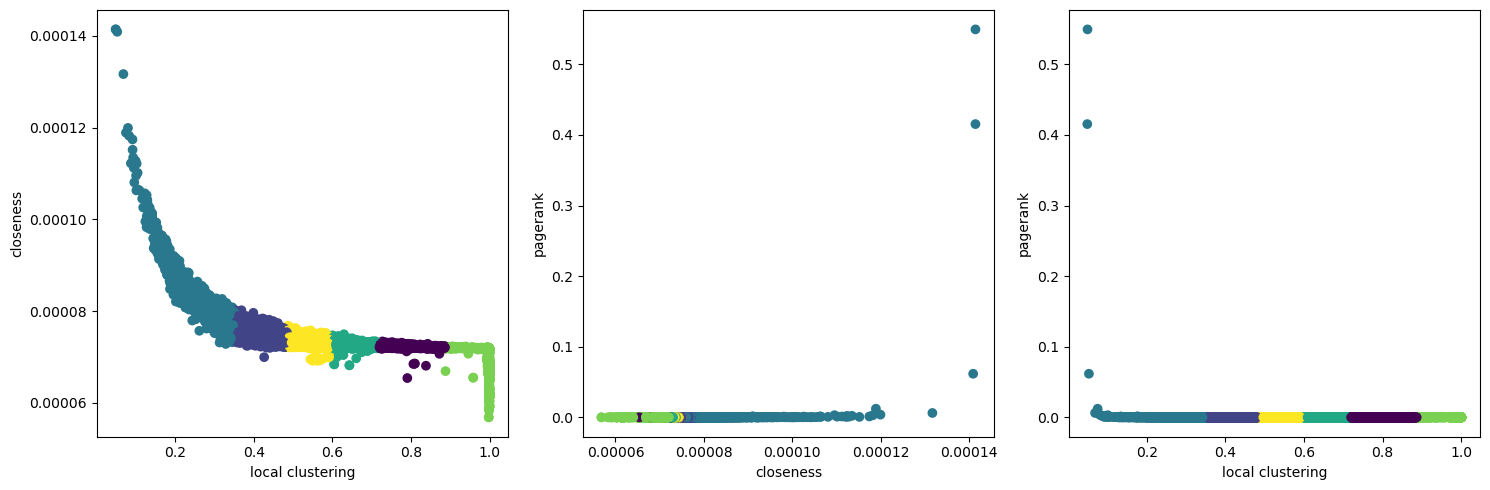

In [174]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(embedding_points[:, 0], embedding_points[:, 1], c=pred)
axs[0].set_xlabel("local clustering")
axs[0].set_ylabel("closeness")

axs[1].scatter(embedding_points[:, 1], embedding_points[:, 2], c=pred)
axs[1].set_xlabel("closeness")
axs[1].set_ylabel("pagerank")

axs[2].scatter(embedding_points[:, 0], embedding_points[:, 2], c=pred)
axs[2].set_xlabel("local clustering")
axs[2].set_ylabel("pagerank")

plt.tight_layout()
plt.savefig("plot.png", format="png")
plt.show()

/tmp/ipykernel_518/1538628261.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(np.unique(pred)))  # tab10 for 10 distinct colors, tab20 for 20


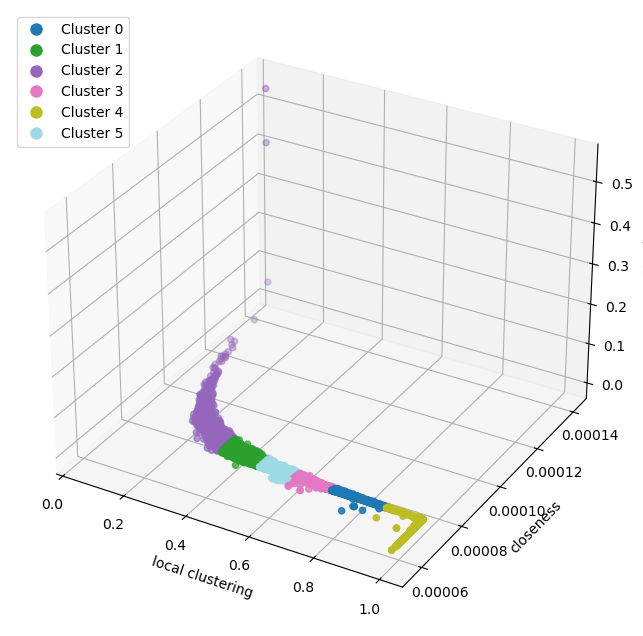

In [175]:
# Extract coordinates
x = embedding_points[:, 0]
y = embedding_points[:, 1]
z = embedding_points[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use a discrete colormap for more distinct colors
cmap = plt.cm.get_cmap('tab20', len(np.unique(pred)))  # tab10 for 10 distinct colors, tab20 for 20

# Plot the points
scatter = ax.scatter(x, y, z, c=pred, cmap=cmap, marker='o', s=20)

# Add labels
ax.set_xlabel('local clustering')
ax.set_ylabel('closeness')
ax.set_zlabel('pagerank')

# Create a legend
unique_clusters = np.unique(pred)
colors = [cmap(i) for i in range(len(unique_clusters))]
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
               markerfacecolor=color, markersize=10)
    for cluster, color in zip(unique_clusters, colors)
]

ax.legend(handles=legend_elements, loc='upper left')

# Show the plot
plt.savefig("plot3d.png", format="png")
plt.show()

In [165]:
_, clust_indexes, clust_sizes = np.unique(pred, return_index=True, return_counts=True)
print(clust_sizes)

for i in range(0, k):
    print(f"=====>Cluster {i}, size {clust_sizes[i]}")

    cluster_node_indices = np.where(pred == i)[0]
    
    cards_in_cluster = [g2.vp["vName"][random.choice(cluster_node_indices)] for _ in range(0, 20)]
    cards_in_cluster.sort()

    query = ""
    for name in cards_in_cluster:
        query += f"!\"{name}\" or "
    print(query.removesuffix(" or "))

[2196  629 2527 3765  547 2227 1267 2575 1691 1223]
=====>Cluster 0, size 2196
!"Aether Snap" or !"Aetherspouts" or !"Ajani, Nacatl Pariah" or !"Ancient Crab" or !"Axgard Cavalry" or !"Cruelclaw's Heist" or !"Dimir Infiltrator" or !"Guild Summit" or !"Happily Ever After" or !"Haunted Screen" or !"Inquisitive Glimmer" or !"Inspiring Overseer" or !"Into the North" or !"Old Rutstein" or !"Ondu Spiritdancer" or !"Patron of the Arts" or !"Treasured Find" or !"Vat Emergence" or !"Vault Robber" or !"Verdant Force"
=====>Cluster 1, size 629
!"Acid Rain" or !"Aetherling" or !"Assimilation Aegis" or !"Barishi" or !"Carrion Rats" or !"Custody Battle" or !"Deadeye Plunderers" or !"Fork in the Road" or !"Guul Draz Vampire" or !"Jaya Ballard, Task Mage" or !"Lita, Mechanical Engineer" or !"Mana Vortex" or !"Penumbra Wurm" or !"Remembrance" or !"Saprazzan Legate" or !"Shunt" or !"Skirsdag High Priest" or !"Temporary Lockdown" or !"Treasury Thrull" or !"Vivisection Evangelist"
=====>Cluster 2, size 25

In [13]:
def get_representative_points(data, pred, n_representatives=3):
    # Determine the unique clusters
    unique_clusters = np.unique(pred)
    # Create an array to hold the indexes of representative points
    representative_indexes = np.zeros((len(unique_clusters), n_representatives), dtype=int)

    for i, cluster in enumerate(unique_clusters):
        # Get indexes of points belonging to the current cluster
        cluster_indexes = np.where(pred == cluster)[0]
        # Get the data points in the current cluster
        cluster_points = data[cluster_indexes]
        # Compute the centroid of the cluster
        centroid = cluster_points.mean(axis=0).reshape(1, -1)

        # Step 1: Find the closest point to the centroid
        closest_idx = np.argmin(np.linalg.norm(cluster_points - centroid, axis=1))
        representatives = [cluster_indexes[closest_idx]]

        # Step 2: Find the farthest point from the most recently selected point
        distances_from_centroid = np.linalg.norm(cluster_points - centroid, axis=1)
        farthest_idx = np.argmax(distances_from_centroid)
        representatives.append(cluster_indexes[farthest_idx])

        # Step 3: Iteratively find the farthest point from the last selected representative
        while len(representatives) < n_representatives:
            distances = np.linalg.norm(cluster_points - data[representatives[-1]], axis=1)
            # Exclude points already selected
            for idx in representatives:
                distances[cluster_indexes == idx] = -np.inf  # Set distance to -inf to ignore them
            next_farthest_idx = np.argmax(distances)
            representatives.append(cluster_indexes[next_farthest_idx])

        # Store the representative indexes in the array
        representative_indexes[i, :] = np.array(representatives)
    
    return representative_indexes

# Example usage
# data: Nx3 numpy array of points
# pred: N-length array of cluster labels
representatives = get_representative_points(embedding_points, pred, n_representatives=3)
i = 0
for repres_for_this_cluster in representatives:
    names = ""
    coords = ""
    for v in g2.vertices():
        if g2.vp["vName"][v] in [g2.vp["vName"][index] for index in repres_for_this_cluster]:
            names += f"!\"{g2.vp["vName"][v]}\" or "
            coords += f"({g2.vp["vLocClusteringMNorm"][v]:.3e}, {g2.vp["vClosenessMNorm"][v]:.3e}, {g2.vp["vPagerankMNorm"][v]:.3e})"
    print(f"Cluster {i}\n{names.removesuffix(" or ")}\n{coords}")
    i += 1

Cluster 0
!"Alela, Cunning Conqueror" or !"Firesong and Sunspeaker" or !"Contaminated Drink"
(5.546e-01, 7.369e-05, 4.876e-05)(5.231e-01, 7.265e-05, 2.918e-05)(5.868e-01, 7.392e-05, 5.089e-05)
Cluster 1
!"Oversoul of Dusk" or !"Concord with the Kami" or !"Auspicious Arrival"
(9.223e-01, 7.199e-05, 1.621e-05)(9.939e-01, 7.183e-05, 1.335e-05)(1.000e+00, 6.199e-05, 1.450e-05)
Cluster 2
!"Keep Safe" or !"Plumb the Forbidden" or !"Unsummon"
(3.808e-01, 7.465e-05, 7.864e-05)(3.393e-01, 7.783e-05, 1.463e-04)(2.799e-01, 7.619e-05, 1.292e-04)
Cluster 3
!"Shadow of Doubt" or !"Thieving Magpie" or !"Icefeather Aven"
(7.588e-01, 7.220e-05, 1.910e-05)(7.214e-01, 7.202e-05, 1.538e-05)(8.040e-01, 7.210e-05, 1.881e-05)
Cluster 4
!"Sol Ring" or !"Thriving Moor" or !"Teferi's Ageless Insight"
(4.879e-02, 1.414e-04, 1.289e-03)(2.193e-01, 8.329e-05, 2.806e-04)(2.799e-01, 8.055e-05, 2.060e-04)
Cluster 5
!"Enthusiastic Mechanaut" or !"See the Truth" or !"Unspeakable Symbol"
(4.902e-01, 7.354e-05, 5.163e-05)

## Analysis

In [7]:
def getVertexByCardNames(name_list):
    result = []
    for i, v in enumerate(g2.vertices()):
        if g2.vp["vName"][v] in name_list:
            result.append((i, v))
    return result

In [8]:
def closestPointIndexFrom(index, embed_data, mask):
    distances = np.linalg.norm(embed_data - embed_data[index], axis=1)
    
    mask[index] = True
    distances[mask] = np.inf  # Exclude the points already visited (the actual included)
    return np.argmin(distances)

In [9]:
def basicCardInfo(g, v, index, pred):
    print(f"Name: {g.vp["vName"][v]}")
    print(f"Cluster: {pred[index]}")
    print(f"Coordinates: ({g.vp["vLocClusteringMNorm"][v]:.3e}, {g.vp["vClosenessMNorm"][v]:.3e}, {g.vp["vPagerankMNorm"][v]:.3e})")
    print(f"Appears {g.vp["vCount"][v]} times")

In [10]:
def plotClusterByPoint(index, point, data, pred):
    cluster_indexes = np.where(pred == pred[index])[0]
    cluster_points = data[cluster_indexes]

    target_index = np.where(cluster_points == point)[0]

    plt.scatter(cluster_points[:, 0], cluster_points[:, 1])
    plt.scatter(cluster_points[target_index, 0], cluster_points[target_index, 1], color='red', zorder=1)
    plt.show()

In [163]:
# Where is my card?
card_name = "Elesh Norn, Grand Cenobite"
for v in g2.vertices():
    if g2.vp["vName"][v] == card_name:
        for index in range(0, len(g2.get_vertices())):
            if g2.get_vertices()[index] == v:
                basicCardInfo(g2, v, index, pred)

# carte belle
# Field of Ruin
# 

Name: Elesh Norn, Grand Cenobite
Cluster: 6
Coordinates: (2.954e-01, 8.216e-05, 2.274e-04)
Appears 293 times


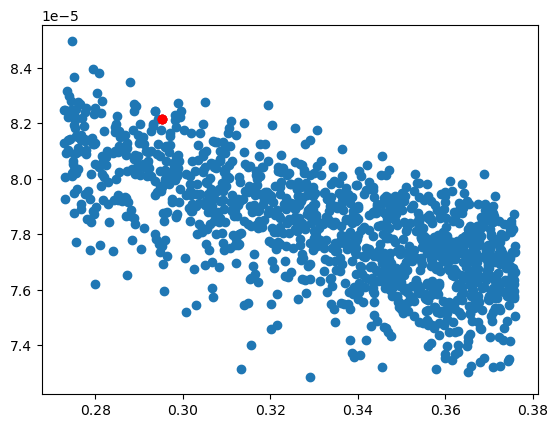

In [164]:
index, v = getVertexByCardNames([card_name])[0]
embed_data = embedding_points.copy()

mask = np.zeros(embed_data.shape[0], dtype=bool)
mask[index] = True # this point is no more valid to be visited
plotClusterByPoint(index, embed_data[index], embed_data, pred)

Name: Kindred Dominance
Cluster: 4
Coordinates: (2.504e-01, 8.192e-05, 2.356e-04)
Appears 273 times


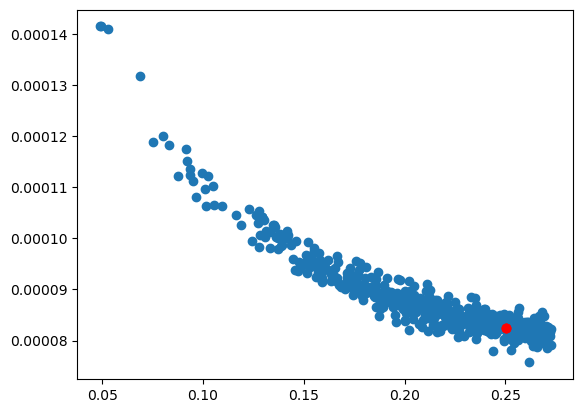

In [162]:
# closest step IN EMBEDDING from a card
next_index = closestPointIndexFrom(index, embed_data, mask)
next_v = g2.get_vertices()[next_index]
basicCardInfo(g2, next_v, next_index, pred)

plotClusterByPoint(index, embed_data[index], embed_data, pred)
index, v = next_index, next_v

In [51]:
degrees = g2.get_total_degrees(g2.get_vertices())
min_degree = degrees.min()
argmin_nodes = [i for i, degree in enumerate(degrees) if degree == min_degree]
print(argmin_nodes)

[13847, 13848]


In [62]:
diam, (card1, card2) = pseudo_diameter(g2, source=13848, weights=g2.ep["eWeightMNorm"])

In [63]:
print(diam, g2.vp["vName"][card1], g2.vp["vName"][card2])

20868.0 Skyclave Squid +2 Mace
